#### Mathematical Preliminaries

$$x^{k+1} = x^k + \lambda_k \frac{b_i - \langle a_i, x^k \rangle}{||a_i||^2}a_i^T$$

This is the equation for the Algebraic Reconstruction Technique (ART) parameterized by row number $i$ ([source](https://en.wikipedia.org/wiki/Algebraic_reconstruction_technique)). We can make this a matrix-vector equation by noticing that the inner product $\langle A_i, x^k \rangle$ is simply the matrix-vector product $Ax^k$ when performed across all rows. The squared norm $||a_i||^2$ translates to $A^TA(\mathbb{1})$. Finally, the transpose vector $a_i^T$ can simply become $A^T$. I find the intuition on this last part hard, so we can check the shape of everything to make sure.

$x_k$ is $1 \times s_1$, where $s_1$ is the reshaped image size

$\lambda_k$ is a scalar

$\mathbb{b}$ is $1 \times s_2$, where $s_2$ is the reshaped sinogram size

$Ax_k$ is a vector of the same dim as $\mathbb{b}$

$A: \mathbf{R}^{s_1} \rightarrow \mathbf{R}^{s_2} \Rightarrow A \in \mathbf{R}^{s_2 \times s_1}$

$A^TA(\mathbb{1})$ is $1 \times s_2$

$A^T \in \mathbf{R}^{s_1 \times s_2}$

$a_i^T$ is $s_2 \times 1$. In the original equation, this will be a dot product with the numerator of the fraction, which is $1 \times s_2$. This is in effect the application of $A^T$ to the numerator, when expanded to all the rows.

Thus, for the final equation, we have

$$ x^{k+1} = x^k + \lambda_k \frac{A^T(\mathbb{b} - Ax^k)}{A^TA(\mathbb{1})} $$

This will update the image vector $x$ iteratively based on the projection and backprojection operators $A$ and $A^T$. This equation is actually quite intuitive. The numerator of the fraction says "project our current image to a sinogram, compare that to the sinogram we're given, and backproject the difference between them." This will be an image. The denominator says "project an all white image to a sinogram, and then backproject it back into an image." This image measures how much a composed backprojection and projection impact each pixel (almost like the eigenvalues for each pixel), and we divide by this image to "undo" the scaling caused by these two operations. This way, we can get a better estimate of what the image adjustment computed in the numerator should be. Finally, we multiply by $\lambda_k$, which is almost like a learning rate in gradient descent.

It seems that the original algorithm was desgined to have matrices for $A$ and $A^T$, but because those matrices would vary in size depending on input and deriving the math there is beyond the scope of our project, we will the projection algorithm from $\texttt{util.py}$ and our own backprojection code here. Other implementations of the ART algorithm use premade $\texttt{radon}$ and $\texttt{iradon}$ functions here, but part of our value-add is a fully transparent, nearly-from-scratch implementation, which doesn't seem to exist online, or is not easily accesible yet. Should we replace the operators later on, it will be with matrices rather than library functions. It will be a big achievement to implement ART without any image transforms from libraries, and just on top of numpy and scipy.fft.

#### Code begins below

In [42]:
import util
import fbp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [43]:
angles = np.linspace(0, 180, 180, endpoint=False)

# define operators
A = lambda x: util.project_array(x, angles)
AT = lambda x: fbp.backproject(x, angles)

In [44]:
# load image
img = Image.open('images/phantom.png')
img, startX, startY = util.pad_img(img)
sino = util.projection(img, angles)
b = sino

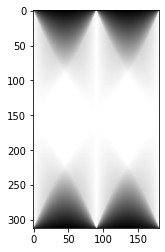

In [45]:
ones = np.ones((sino.shape[0], sino.shape[0]))
Aones = A(ones)
plt.imshow(Aones, cmap='gray')

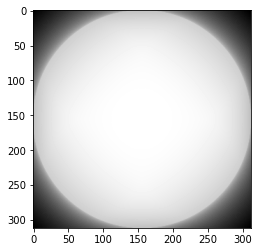

In [46]:
denom = AT(Aones)
plt.imshow(denom, cmap='gray')

Not all white like the image we put in. The operators are not perfect inverses, as we know from the experiments with filtered back projection. The filter is necessary for better, but still not perfect inversion, is not present here.

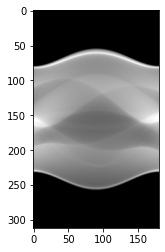

In [47]:
xk = np.zeros((sino.shape[0], sino.shape[0])) # initial xk
A_xk = A(xk)
diff = b - A_xk
plt.imshow(diff, cmap='gray')

Difference begins as just the phantom sinogram, since projection of the black image gives a black sinogram and b is the projection of the phantom. Now backprojecting the diff sinogram.

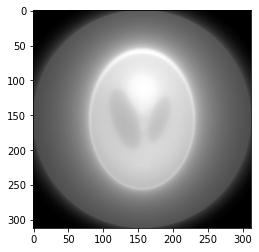

In [48]:
numerator = AT(diff)
plt.imshow(numerator, cmap='gray')

Not great, but a start.

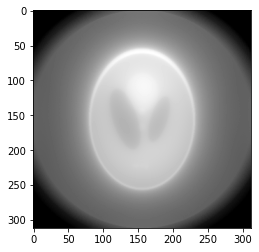

In [49]:
update = numerator / denom
plt.imshow(update, cmap='gray')

Update $x_k$ based on this info.

In [50]:
xk = xk + update * 0.5

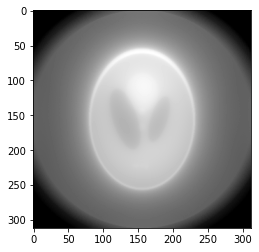

In [51]:
plt.imshow(xk, cmap='gray')

In [55]:
def diff_image(A, AT, b, xk):
    sino_diff = b - A(xk)
    image = AT(sino_diff)

    return image

Now let's run hundreds of iterations with a downscaled version of the phantom.

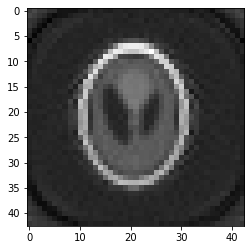

In [56]:
img = Image.open('images/phantom_small.png')
img, startX, startY = util.pad_img(img)

sino = util.projection(img, angles)
b = sino
xk = np.zeros((sino.shape[0], sino.shape[0])) # initial xk
ones = np.ones((sino.shape[0], sino.shape[0]))
denom = AT(A(ones)) # speed up by precomputing denominator

errors = []
l = 1
for i in range(200):
    numerator = diff_image(A, AT, b, xk)
    xk = xk + l * numerator / denom

    mae = np.mean(np.abs(update))
    errors.append(mae)

plt.imshow(xk, cmap='gray')

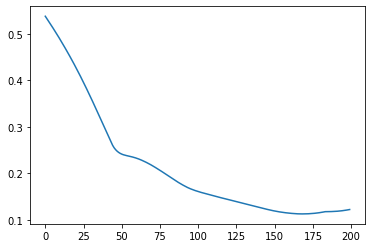

In [ ]:
plt.plot(errors)

Now let's see the error as a surface $L$ parameterized by number of iterations and learning rate $\lambda_k$

In [114]:
errors = {}

for l in np.linspace(0.1, 1, 10):
    # reset optimization for every new lambda

    xk = np.zeros((sino.shape[0], sino.shape[0])) # initial xk
    # b, A, AT, denom are the same as above
    
    for i in range(200):
        numerator = diff_image(A, AT, b, xk)
        update = l * numerator / denom
        xk = xk + update

        me = np.mean(update)
        errors[(l, i)] = me

Text(0.5, 0, 'Mean Error')

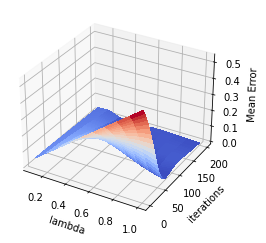

In [115]:
%matplotlib inline
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X, Y = np.meshgrid(np.linspace(0.1, 1, 10), np.array(range(200)))

# look up error for each l and iteration
Z = np.array([errors[(l, i)] for l, i in zip(X.flatten(), Y.flatten())]).reshape(X.shape)

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('lambda')
ax.set_ylabel('iterations')
ax.set_zlabel('Mean Error')

In [146]:
def ART(A, AT, b, iters, l=1, save_gif=False):
    xk = np.zeros((b.shape[0], b.shape[0])) # initial xk
    ones = np.ones((b.shape[0], b.shape[0]))
    denom = AT(A(ones)) # speed up by precomputing denominator

    frames = []
    for i in range(iters):
        numerator = diff_image(A, AT, b, xk)
        update = l * numerator / denom
        xk = xk + update

        if save_gif:
            frames.append(Image.fromarray(
                xk / np.max(xk) * 255
            ))

    if save_gif:
        frames[0].save(
            'art.gif', format='GIF', 
            append_images = frames[1:], 
            save_all=True, duration=45, loop=0
        )

    return xk

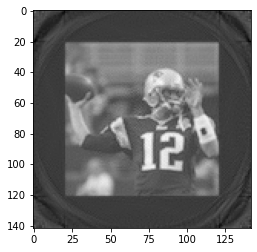

In [149]:
img = Image.open('images/brady-medium.jpg')
img, startX, startY = util.pad_img(img)
angles = np.linspace(0, 180, 180, endpoint=False)
b = util.projection(img, angles)

xk = ART(A, AT, b, 300, save_gif=True)
plt.imshow(xk, cmap='gray')

##### Why this algorithm is slow
The algorithm would be much faster if we could come up with the sparse matrices $A$ and $A^T$ that describe projection and unfiltered backprojection, respectively. Then, this would come down to a simple numerical algorithm as originally intended. In integrating our own functions as the operators $A$ and $A^T$, we continue to work in the image space and sinogram space, and each "operator" actually consists of a full sequential algorithm in itself. This slows this down quite a bit, and we combat this by using a downsampled version of the Shepp-Logan phantom to demonstrate results over a large number of iterations.